In [1]:
import os, time, argparse, shutil, random
from collections import defaultdict, Counter
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from tensorboardX import SummaryWriter

from dataset import *

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def train(args, epoch, model, criterion, optimizer, train_loader, writer, iters):
    
    model.train()
    
    for batch_idx, sample in enumerate(train_loader):
        data = sample['image']
        target = sample['keypoints']
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        data, target = data.type(torch.cuda.FloatTensor), target.type(torch.cuda.FloatTensor)
        
        target = target.reshape(target.shape[0], -1,)
        output = model(data)
        
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0 and not batch_idx==0 :
            print('Train Epoch:{}/{} [{}/{} ({:.0f}%)]  Loss:{:.4f}'.format(
                epoch + 1, args.epochs,
                batch_idx * len(data), len(train_loader) * len(data),
                100.0 * batch_idx / len(train_loader), loss.item()
            ), end='\r')
            writer.add_scalar('loss', loss.item(), iters) # add to tensorboard
            iters += 1
            count=0
    return loss.item(), iters

def test(args, epoch, model, criterion, test_loader, writer, iters):
    
    model.eval()
    
    for batch_idx, sample in enumerate(test_loader):
        data = sample['image']
        target = sample['keypoints']
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        data, target = data.type(torch.cuda.FloatTensor), target.type(torch.cuda.FloatTensor)
        
        target = target.reshape(target.shape[0], -1, )
        output = model(data)
        loss = criterion(output, target)
        
        if batch_idx % args.log_interval == 0 and not batch_idx==0 :
            print('Val Epoch:{}/{} [{}/{} ({:.0f}%)]  Val loss:{:.4f}'.format(
                epoch + 1, args.epochs,
                batch_idx * len(data), len(test_loader) * len(data),
                100.0 * batch_idx / len(test_loader), loss.item()
            ))
            writer.add_scalar('valloss', loss.item(), iters) # add to tensorboard
    return loss.item()

def save_checkpoint(state, is_best, n_keypoints, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'checkpoints/model_best.kp%i.pth.tar' % n_keypoints)

def resume(args, ckpt,model):
    if os.path.isfile(ckpt):
        print('==> loading checkpoint {}'.format(ckpt))
        checkpoint = torch.load(ckpt)
        args.start_epoch = checkpoint['epoch']
        best_loss = checkpoint['loss']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer = checkpoint['optimizer']
        iters=checkpoint['iters']
        print("==> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
        return model,optimizer,args.start_epoch,best_loss,iters
    else:
        print("==> no checkpoint found at '{}'".format(args.resume))
    
def adjust_lr(args, optimizer, epoch, decay=20):
    """
        adjust the learning rate initial lr decayed 10 every 20 epoch
    """
    lr=args.lr*(0.1**(epoch//decay))
    for param in optimizer.param_groups:
        param['lr'] = lr

def get_model(modelname, n_keypoints, channels=1):
    model = None
    if modelname == 'mobilenetv2':
        model = torchvision.models.mobilenet_v2(pretrained=True)
        model.features._modules['0'][0] = nn.Conv2d(channels, 32,
                                                    kernel_size=(3,3),
                                                    stride=(2,2),
                                                    padding=(1,1),
                                                    bias=False)
        layers = [
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1280, out_features=n_keypoints*2, bias=True)
        ]
        model.classifier = nn.Sequential(*layers)
    return model

In [3]:
def get_args():
    args = {
        'batch_size': 8,
        'lr': 1e-3,
        'start_epoch': 0,
        'epochs': 50,
        'seed': 0,
        'log_interval': 10,
        'resume': None,
        'train_csv': 'data/training.csv',
        'test_csv': 'data/test.csv',
        'idlookup_table': 'data/IdLookupTable.csv'
    }
    return args

In [4]:
def get_dataset_indices(file, n_keypoints):
    df = pd.read_csv(file)
    notnan = df.apply(lambda x: np.sum(~x[:30].isnull()), axis=1)
    return notnan[notnan == n_keypoints*2].reset_index(drop=True).index

def get_dataloaders(n_keypoints, use_val=True):
    dataset = FacialKeyPointsDataset(csv_file=args.train_csv,
                                     n_keypoints=n_keypoints,
                                     size=(96,96))
    indices = get_dataset_indices(file=args.train_csv, n_keypoints=n_keypoints)
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    
    if use_val:
        train_idx, val_idx = train_test_split(indices, test_size=0.15,
                                      shuffle=True, random_state=args.seed)
        train_sampler = SubsetRandomSampler(train_idx)
        val_samper = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset,
                              sampler=train_sampler,
                              batch_size=args.batch_size,
                              drop_last=True,
                              **kwargs)
        val_loader = DataLoader(dataset,
                            sampler=val_samper,
                            batch_size=args.batch_size*2,
                            drop_last=True,
                            **kwargs)
    else:
        train_sampler = SubsetRandomSampler(indices)
        train_loader = DataLoader(dataset,
                                  sampler=train_sampler,
                                  batch_size=args.batch_size,
                                  drop_last=True,
                                  **kwargs)
        val_loader = None
    
    return train_loader, val_loader
        
def main(modelname, n_keypoints, use_val=True):
    """
    Args:
        n_keypoints(int): number of keypoints (x,y) in dataset
        use_val(bool): False when using all train data for predictions,
                       otherwise, split train for testing
    """
    args.cuda = torch.cuda.is_available()
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    # SmoothL1Loss/Huber loss is less sensitive to outliers than MSELoss
    # absolute squared term < 1, use L1, else use L2
    criterion = nn.SmoothL1Loss()
    model = get_model(modelname=modelname, n_keypoints=n_keypoints)
    optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.999))
    writer = SummaryWriter('logs/'+datetime.now().strftime('%B-%d'))
    best_loss = 1e+5
    best_loss_val = 1e+5
    iters = 0
    
    train_loader, val_loader = get_dataloaders(n_keypoints)
    
    assert model is not None
    if args.cuda: model.cuda()
    
    # resume training 
    if args.resume:
        model, optimizer, args.start_epoch, best_loss, iters = resume(args, args.resume, model)

    # train loop
    for epoch in range(args.start_epoch, args.epochs):
        adjust_lr(args, optimizer, epoch, decay=5)
        t1 = time.time()
        loss, iters = train(args, epoch, model,
                            criterion, optimizer,
                            train_loader, writer, iters)
        is_best = loss < best_loss
        best_loss = min(best_loss, loss)
        
        state = {
            'epoch':epoch,
            'state_dict':model.state_dict(),
            'optimizer':optimizer,
            'loss':best_loss,
            'iters': iters,
        }
        
        if use_val:
            loss_val = test(args, epoch, model, criterion,
                            val_loader, writer, iters)
            best_loss_val = min(best_loss_val, loss_val)
            state['loss_val'] = best_loss_val
            
        save_checkpoint(state, is_best, n_keypoints)
    writer.close()

In [5]:
args = dotdict(get_args())
modelname = 'mobilenetv2'
main(modelname, n_keypoints=4, use_val=False)
main(modelname, n_keypoints=15, use_val=False)

In [6]:
modelname = 'mobilenetv2'
# trained on subset of data with 15 keypoints
model15 = get_model(modelname, n_keypoints=15) # n=2284
#model.mobilenetv2.normalized.aug/
model15.load_state_dict(torch.load('checkpoints/model_best.kp15.pth.tar')['state_dict'])
model15.eval()

# trained on full dataset but predicting 4 keypoints for all
model4 = get_model(modelname, n_keypoints=4) #n=4755
model4.load_state_dict(torch.load('checkpoints/model_best.kp4.pth.tar')['state_dict'])
model4.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [7]:
def unnormalize_kp(df_train, output):
    kp_mean = df_train.iloc[:,:30].stack().mean()
    kp_std = df_train.iloc[:,:30].stack().std()
    return (output * kp_std) + kp_mean
    
def get_img_and_output(model, df, idx):
    img = np.array(df.iloc[idx,1].split())
    img = img.astype(np.float32).reshape(96,96)
    img /= 255.0
    img_input = np.expand_dims(img, axis=0)
    img_input = np.expand_dims(img_input, axis=0)
    output = model(torch.from_numpy(img_input))
    output = output.detach().numpy()
    df_train = pd.read_csv(args.train_csv)
    output = unnormalize_kp(df_train, output)
    output = output.astype(np.int16)
        
    return img, output.reshape(-1,2)

def show_keypoints(img, keypts, outfile=None):
    plt.scatter(keypts[:,0], keypts[:,1], s=32, c='w', marker='h')
    plt.imshow(img)
    if outfile:
        plt.savefig(outfile)
        print('Saved to', outfile)
        
def display_samples(model, df, outfile):
    fig = plt.figure(figsize=(10, 10))
    fig.tight_layout()
    rows, columns = 3, 3
    for i in range(columns*rows):
        idx = random.randint(0, df.shape[0])
        img, output = get_img_and_output(model, df, idx)
        fig.add_subplot(rows, columns, i + 1)
        show_keypoints(img, output)
    plt.show()
    if outfile:
        fig.savefig(outfile)
        print('Saved to', outfile)
        
def show_example(model, df, idx, outfile):
    img, output = get_img_and_output(model, df, idx)
    show_keypoints(img, output, outfile)

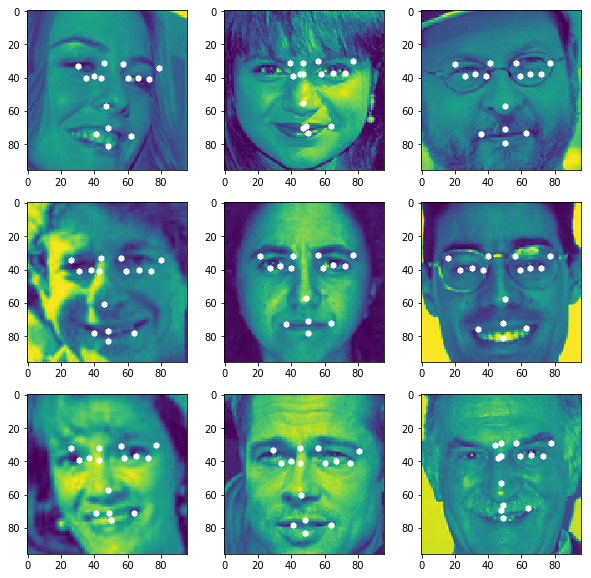

Saved to sample.15kp.png


In [8]:
# display predictions on test samples
args = dotdict(get_args())
df = pd.read_csv('data/test.csv')
display_samples(model15, df, 'samples/sample.15kp.png')

Saved to sample1.png


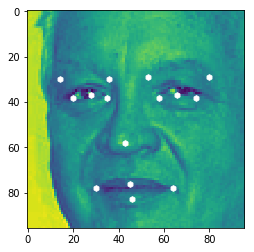

In [46]:
df = pd.read_csv('data/test.csv')
rand_idx = random.randint(0, df.shape[0])
show_example(model15, df, rand_idx, 'samples/sample1.png')

Saved to sample2.png


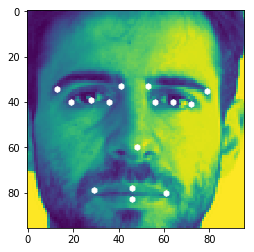

In [47]:
rand_idx = random.randint(0, df.shape[0])
show_example(model15, df, rand_idx, 'samples/sample2.png')

In [15]:
def create_submission():
    submission = []
    df = pd.read_csv(args.test_csv)
    df_train = pd.read_csv(args.train_csv)
    df_idlookup = pd.read_csv(args.idlookup_table)
    kp_cols15 = df_idlookup[df_idlookup['ImageId'] == 1]['FeatureName'] # sample with 15 keypoints
    kp_cols4 = df_idlookup[df_idlookup['ImageId'] == 1481]['FeatureName'] # sample with 4 keypoints
    total = df.shape[0]
    
    for id in df['ImageId']:
        print(id, total, end='\r')
        img = np.array(df[df['ImageId'] == id]['Image'].values[0].split())
        img = img.astype(np.float32).reshape(96,96)
        img /= 255.0
        img_input = np.expand_dims(img, axis=0)
        img_input = np.expand_dims(img_input, axis=0)

        keypoints_include = df_idlookup[df_idlookup['ImageId'] == id]['FeatureName']
        if len(keypoints_include) > 8:
            output = model15(torch.from_numpy(img_input))
        else:
            output = model4(torch.from_numpy(img_input))

        keypoints = output.detach().numpy()[0]
        keypoints = unnormalize_kp(df_train, keypoints)
        keypoints = keypoints.astype(np.int16)

        if len(keypoints_include) > 8:
            keypoints = keypoints[kp_cols15.isin(keypoints_include)]
        else:
            keypoints = keypoints[kp_cols4.isin(keypoints_include)]

        for i in range(len(keypoints)):
            submission.append(keypoints[i])

    write_submission(submission)

def write_submission(submission):
    df_submit = pd.DataFrame(submission)
    df_submit.columns = ['Location']
    df_submit['RowId'] = list(range(1,df_submit.shape[0]+1))
    df_submit = df_submit[['RowId', 'Location']]
    df_submit['Location'] = df_submit['Location'].apply(lambda x: x if x > 0 else 0)
    df_submit.to_csv('submissions/submission.csv', index=False)
    print('wrote to submission.csv', df_submit.shape)

In [16]:
create_submission()

wrote to submission.csv (27124, 2)317831783178317831783


In [17]:
!kaggle competitions submit -c facial-keypoints-detection -f submissions/submission.csv -m "test"

100%|█████████████████████████████████████████| 228k/228k [00:00<00:00, 387kB/s]
Successfully submitted to Facial Keypoints Detection